In [161]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np
import data_utils as du
import plotters
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.statistics import check_seasonality,plot_acf,plot_pacf,remove_seasonality,remove_trend,stationarity_test_adf
from darts.utils.statistics import extract_trend_and_seasonality
import os
from meteostat import Point, Hourly
import holidays
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from entsoe import EntsoeRawClient
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

<Axes: xlabel='start_time'>

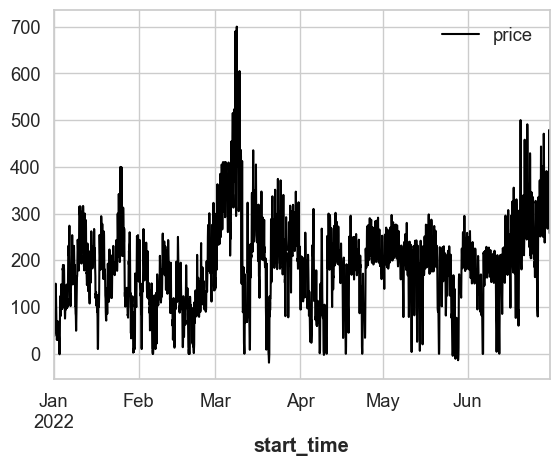

In [162]:
day_price_df = pd.read_csv('./data/Day-ahead_Prices_60min.csv')

day_price_df[['start_time', 'end_time']] = day_price_df['MTU (CET/CEST)']\
                                                .str.split(' - ', expand=True)
day_price_df.drop(columns=['MTU (CET/CEST)', 'BZN|DE-LU', 'Currency', 'end_time']
                , inplace=True) # assumes all currency same in same region
day_price_df.rename(columns={
    'Day-ahead Price [EUR/MWh]': 'price'
}, inplace=True)

day_price_df['start_time'] = pd.to_datetime(day_price_df['start_time'], format='%d.%m.%Y %H:%M')
day_price_ts = day_price_df.set_index('start_time') 

day_price_ts.plot()


In [163]:
day_price_df[day_price_df['price'].isna()]

missing_row = du.show_nrows_around_target(day_price_df, 'price', 5)


NaN at index 2042:
       price          start_time
2037  244.98 2022-03-26 21:00:00
2038  244.94 2022-03-26 22:00:00
2039  237.75 2022-03-26 23:00:00
2040  235.00 2022-03-27 00:00:00
2041  221.93 2022-03-27 01:00:00
2042     NaN 2022-03-27 02:00:00
2043  214.02 2022-03-27 03:00:00
2044  212.00 2022-03-27 04:00:00
2045  211.09 2022-03-27 05:00:00
2046  210.31 2022-03-27 06:00:00
2047  214.03 2022-03-27 07:00:00
----------------------------------------


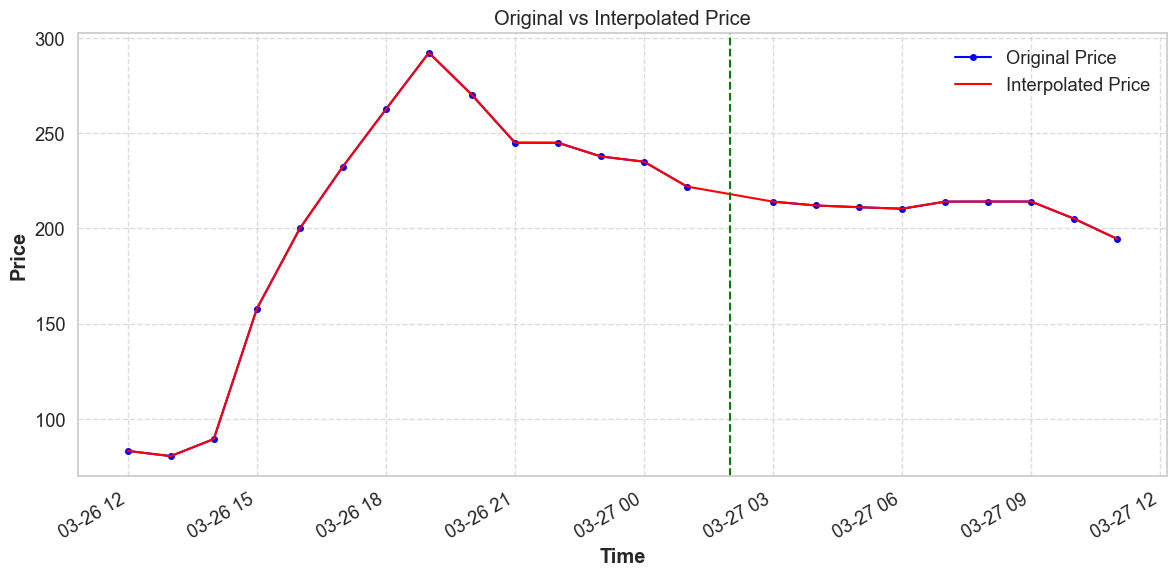

In [164]:
day_price_ts['price_interpolated'] = day_price_ts['price'].interpolate(method='time')

# Analysis
start_date = datetime(2022, 3, 26, 12)
end_date = datetime(2022, 3, 27, 12)
filtered_data = day_price_ts[['price', 'price_interpolated']].loc[
    (day_price_ts.index >= start_date) & (day_price_ts.index < end_date)
]
plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['price'], 'b-o', label='Original Price', markersize=4)
plt.plot(filtered_data.index, filtered_data['price_interpolated'], 'r-', label='Interpolated Price')
plt.title('Original vs Interpolated Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

vertical_line_time = datetime(2022, 3, 27, 2)  # Time for the vertical line
plt.axvline(x=vertical_line_time, color='green', linestyle='--', label='02:00')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show();

In [165]:
zero_price = du.show_nrows_around_target(day_price_df, 'price', 5, 0.0)


NaN at index 1186:
      price          start_time
1181   9.06 2022-02-19 05:00:00
1182   0.10 2022-02-19 06:00:00
1183   3.62 2022-02-19 07:00:00
1184   9.42 2022-02-19 08:00:00
1185   1.94 2022-02-19 09:00:00
1186   0.00 2022-02-19 10:00:00
1187  -0.08 2022-02-19 11:00:00
1188  -0.35 2022-02-19 12:00:00
1189  -0.52 2022-02-19 13:00:00
1190  -0.08 2022-02-19 14:00:00
1191   0.08 2022-02-19 15:00:00
----------------------------------------

NaN at index 2558:
       price          start_time
2553  100.00 2022-04-17 09:00:00
2554   75.92 2022-04-17 10:00:00
2555   41.29 2022-04-17 11:00:00
2556   20.73 2022-04-17 12:00:00
2557    0.07 2022-04-17 13:00:00
2558    0.00 2022-04-17 14:00:00
2559    0.08 2022-04-17 15:00:00
2560   15.00 2022-04-17 16:00:00
2561   66.20 2022-04-17 17:00:00
2562  158.02 2022-04-17 18:00:00
2563  182.55 2022-04-17 19:00:00
----------------------------------------

NaN at index 3492:
      price          start_time
3487  77.04 2022-05-26 07:00:00
3488  51.85 20

<Axes: xlabel='start_time'>

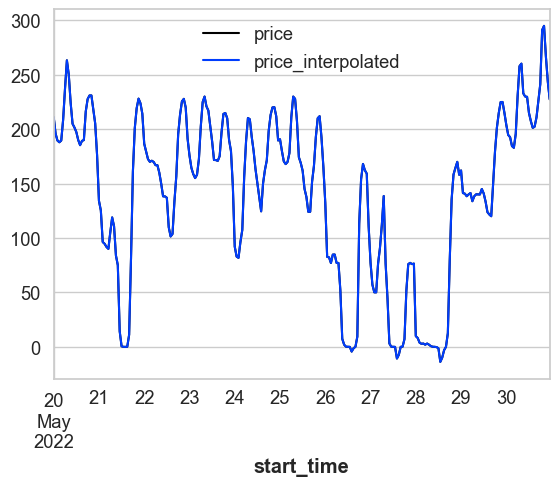

In [166]:
day_price_ts.loc[(day_price_ts.index >= datetime(2022,5,20)) & (day_price_ts.index < datetime(2022,5,31))].plot()

In [167]:
day_price_ts['price'] = day_price_ts['price_interpolated']
day_price_ts = day_price_ts.drop(columns=['price_interpolated'])

In [168]:
day_price_ts = du.add_date_features(day_price_ts)


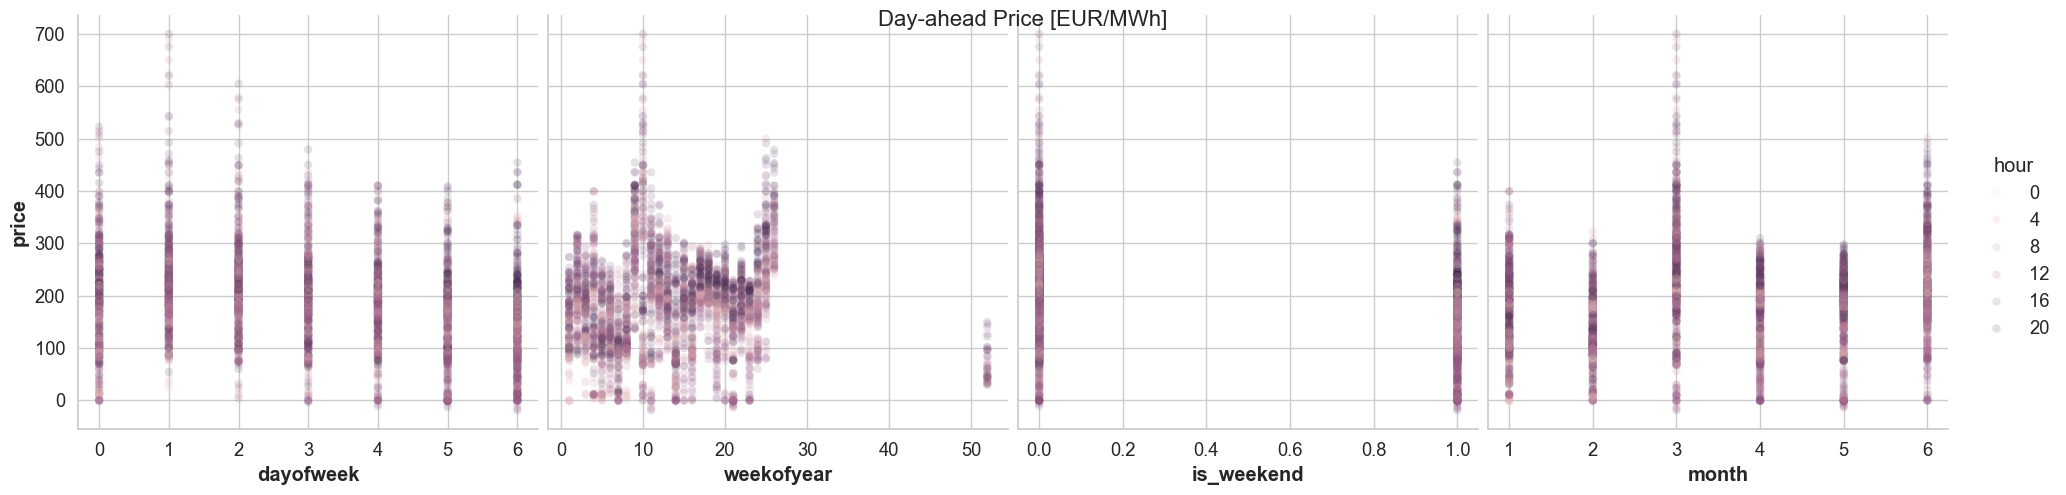

In [169]:
sns.pairplot(day_price_ts,
            hue='hour',
            x_vars=['dayofweek','weekofyear', 'is_weekend', 'month'],
            y_vars='price',
            height=5,
            plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Day-ahead Price [EUR/MWh]', fontsize=16)
plt.show()

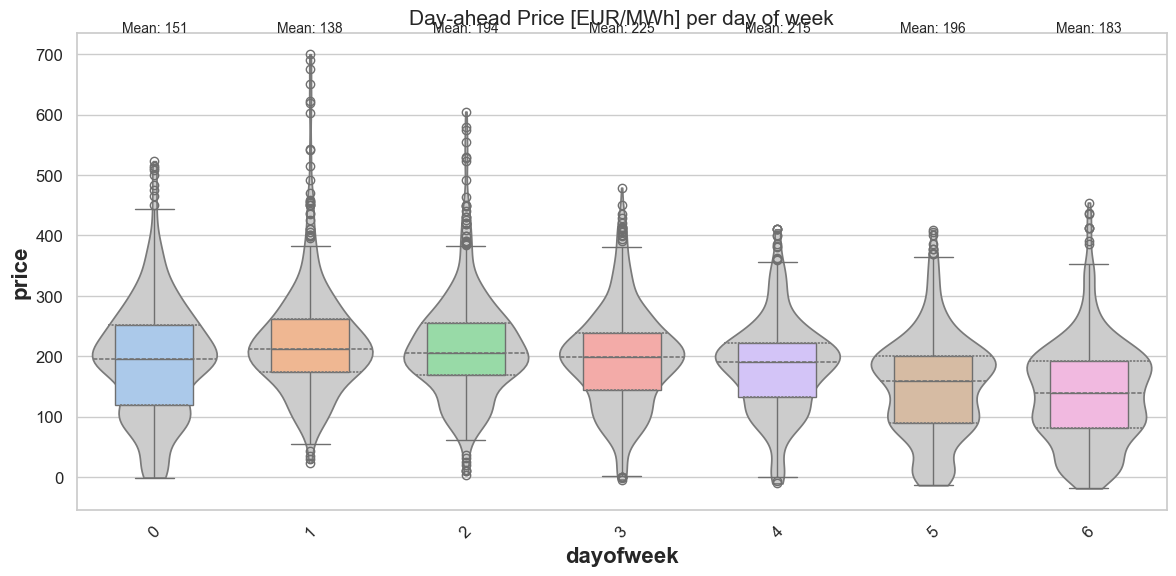

In [170]:
plotters.plot_violin_ts(day_price_ts, 'dayofweek', 'price', 'Day-ahead Price [EUR/MWh] per day of week')

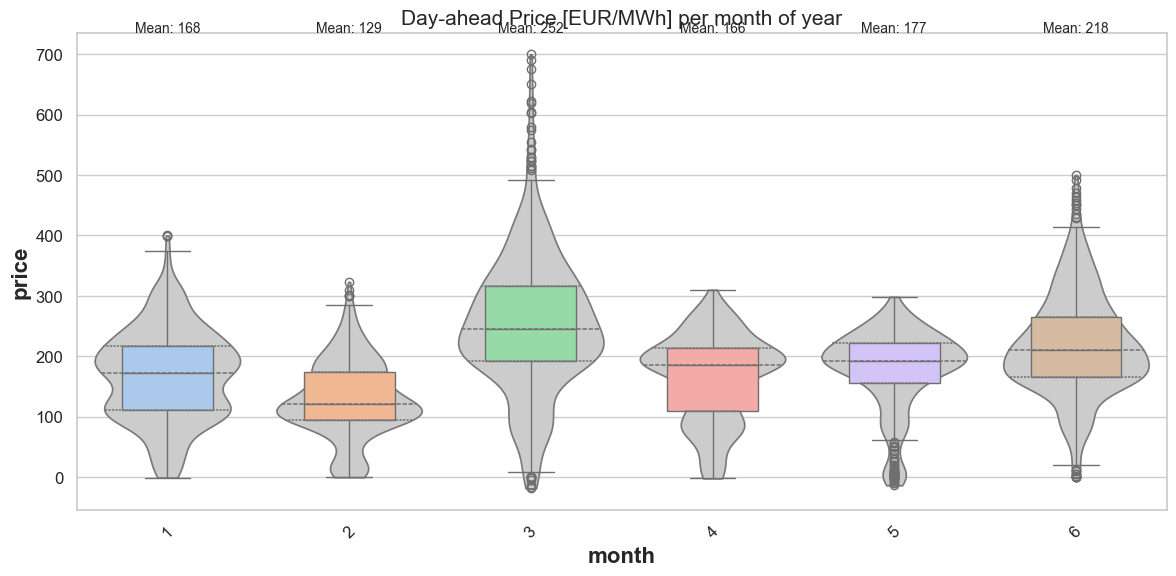

In [171]:
plotters.plot_violin_ts(day_price_ts, 'month', 'price', 'Day-ahead Price [EUR/MWh] per month of year')

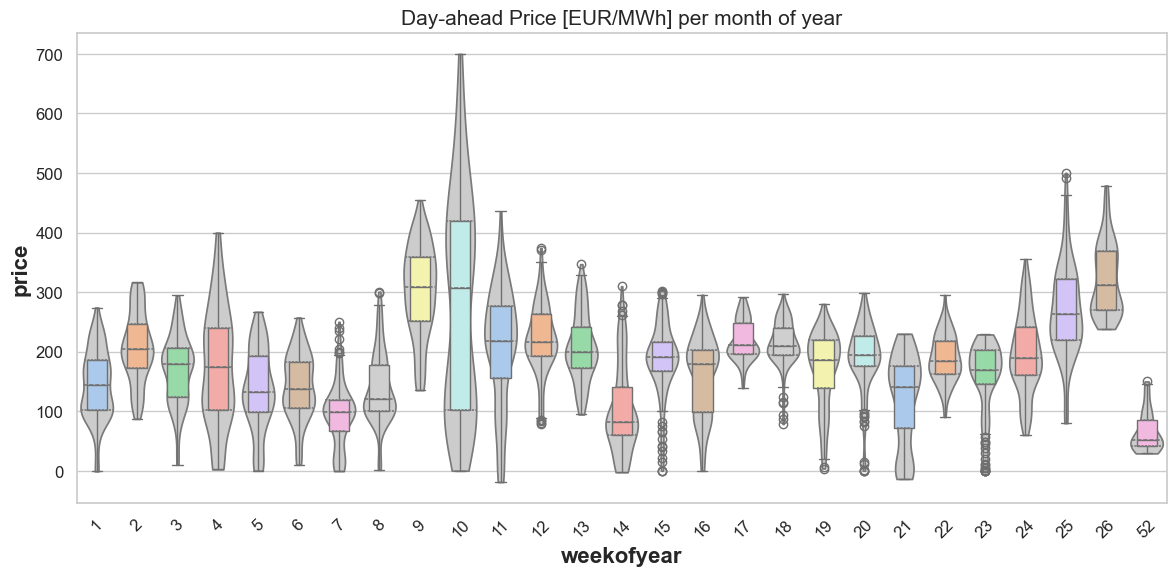

In [172]:
plotters.plot_violin_ts(day_price_ts, 'weekofyear', 'price', 'Day-ahead Price [EUR/MWh] per month of year', False)

### Add temperature

In [173]:
locations = {
    'LU': (49.815273, 6.129583),  # Luxembourg City coordinates
    'DE': (52.520008, 13.404954)  # Berlin coordinates (as an example for Germany)
}

weather_data = du.add_locations_weather(day_price_ts, locations)

In [174]:
merged_data = day_price_ts.merge(weather_data[['temp', 'tsun']], left_index=True, right_index=True, how='left')


In [175]:
import yfinance as yf

vix_close = yf.download('^VIX', start=merged_data.index.min(), end=merged_data.index.max())['Close']
dax_close = yf.download('^GDAXI', start=merged_data.index.min(), end=merged_data.index.max())['Close']
eur_usd_close = yf.download("EURUSD=X", start=merged_data.index.min(), end=merged_data.index.max())['Close']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [176]:
eur_usd_close.columns

Index(['EURUSD=X'], dtype='object', name='Ticker')

In [177]:
merged_data['price_ma_3d'] = merged_data['price'].rolling(window=3).mean()

merged_data['date'] = merged_data.index.date
vix_close['date'] = vix_close.index.date
dax_close['date'] = dax_close.index.date
eur_usd_close['date'] = eur_usd_close.index.date

merged_data = merged_data.merge(vix_close[['date', '^VIX']], 
                                 on='date', 
                                 how='left')

merged_data = merged_data.merge(dax_close[['date', '^GDAXI']], 
                                 on='date', 
                                 how='left')

merged_data = merged_data.merge(eur_usd_close[['date', 'EURUSD=X']], 
                                 on='date', 
                                 how='left')

merged_data.set_index(merged_data.index, inplace=True)
merged_data = merged_data.drop('date', axis=1).rename(columns={'^VIX': 'VIX',
                                                               '^GDAXI': 'DAX',
                                                               'EURUSD=X': 'EURUSD'})


In [178]:
merged_data.set_index('datetime', inplace=True)

In [179]:
plotters.plot_compare_two_col(merged_data, 'price', 'VIX', 'Day-ahead Price [EUR/MWh] vs VIX')

In [180]:
plotters.plot_compare_two_col(merged_data, 'price', 'DAX', 'Day-ahead Price [EUR/MWh] vs DAX')

In [181]:
df_load = pd.read_csv('./data/Forecasted_consumption_202201010000_202207010000_Hour.csv',
                        delimiter=';', parse_dates=['Start date', 'End date'])

df_load = df_load.drop(columns=['End date'])
df_load = df_load.rename(columns={'grid load [MWh] Calculated resolutions': 'grid_load',
                                    'Residual load [MWh] Calculated resolutions': 'residual_load',})

df_load['grid_load'].loc[df_load['grid_load']=='-'] = np.nan
df_load['grid_load'] = df_load['grid_load'].str.replace(',', '').astype(float)

df_load['residual_load'].loc[df_load['residual_load']=='-'] = np.nan
df_load['residual_load'] = df_load['residual_load'].str.replace(',', '').astype(float)

df_load = df_load.set_index('Start date')

/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_65920/4075160306.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_65920/4075160306.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_65920/4075160306.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [182]:
df_DH_generation = pd.read_csv('./data/Forecasted_generation_Day-Ahead_202201010000_202207010000_Hour.csv',
                        delimiter=';', parse_dates=['Start date', 'End date'])

df_DH_generation = df_DH_generation.set_index('Start date')
df_DH_generation= df_DH_generation[['Total [MWh] Original resolutions']]
df_DH_generation = df_DH_generation.rename(columns={'Total [MWh] Original resolutions': 'total_DH_generation'})
df_DH_generation['total_DH_generation'] = df_DH_generation['total_DH_generation']\
                                            .str.replace(',', '').astype(float)

/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_65920/55072728.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [183]:
merged_data = merged_data.join(df_load, how='left')
merged_data = merged_data.join(df_DH_generation, how='left')

merged_data['energy_balance'] = merged_data['total_DH_generation'] - merged_data['grid_load']

In [184]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

drop_col = [
            'price_ma_3d',
            'temp',
            'EURUSD',
            'quarter',
            ]
cleaned_merged_data = merged_data.drop(drop_col, axis=1)

print(cleaned_merged_data.dtypes)

split_date = datetime(2022, 5, 1)
xgb_train, xgb_test = du.ts_train_test_split(cleaned_merged_data, split_date)

X_train, y_train = xgb_train.drop(['price'], axis=1), xgb_train['price']
X_test, y_test = xgb_test.drop(['price'], axis=1), xgb_test['price']

price                  float64
is_weekend                bool
hour                     int32
dayofweek                int32
year                     int32
dayofyear                int32
dayofmonth               int32
month                    int32
weekofyear              UInt32
is_holiday                bool
tsun                   float64
VIX                    float64
DAX                    float64
grid_load              float64
residual_load          float64
total_DH_generation    float64
energy_balance         float64
dtype: object


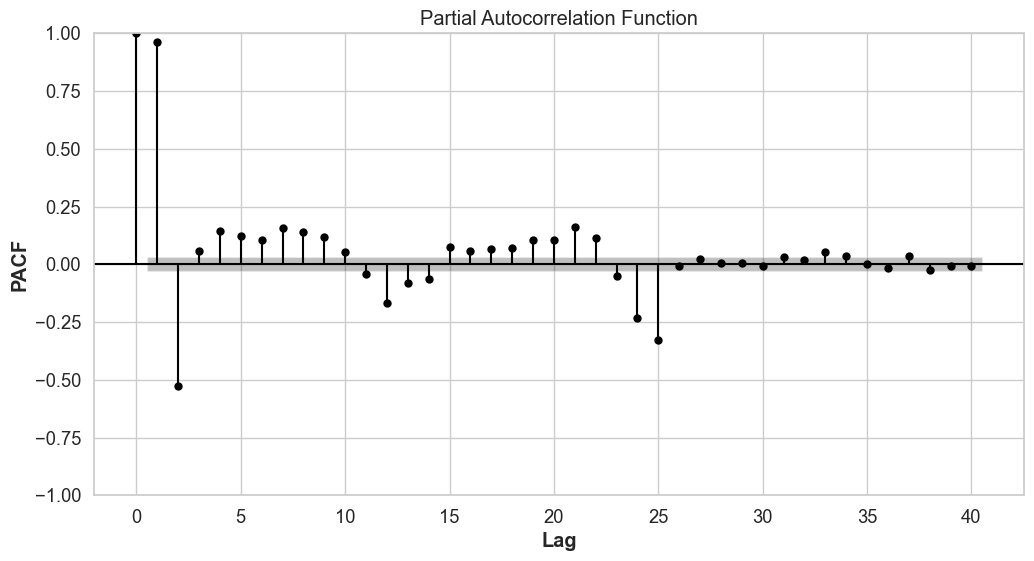

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

series_to_analyze = cleaned_merged_data['price'] if isinstance(xgb_train, pd.DataFrame) else xgb_train

# Create the PACF plot
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(series_to_analyze, ax=ax, lags=40)  # You can adjust the number of lags as needed

# Customize the plot
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('PACF')

# Show the plot
plt.show()

In [186]:
X_train['mean_previous_4_hrs'] = y_train.shift(4).rolling(window='4H', min_periods=1).mean()
X_test['mean_previous_4_hrs'] = y_test.shift(4).rolling(window='4H', min_periods=1).mean()

X_train['mean_previous_3_hrs'] = y_train.shift(3).rolling(window='3H', min_periods=1).mean()
X_test['mean_previous_3_hrs'] = y_test.shift(3).rolling(window='3H', min_periods=1).mean()

X_train['mean_previous_2_hrs'] = y_train.shift(2).rolling(window='2H', min_periods=1).mean()
X_test['mean_previous_2_hrs'] = y_test.shift(2).rolling(window='2H', min_periods=1).mean()

X_train['mean_previous_1_hrs'] = y_train.shift(1)
X_test['mean_previous_1_hrs'] = y_test.shift(1)


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

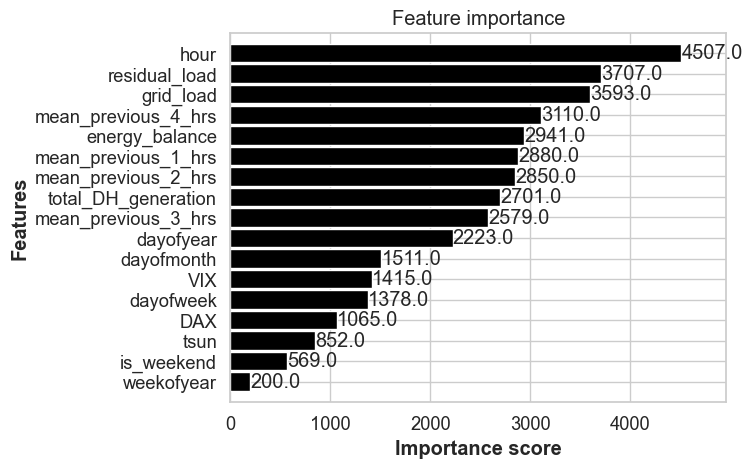

In [187]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

plot_importance(reg, height=0.9)

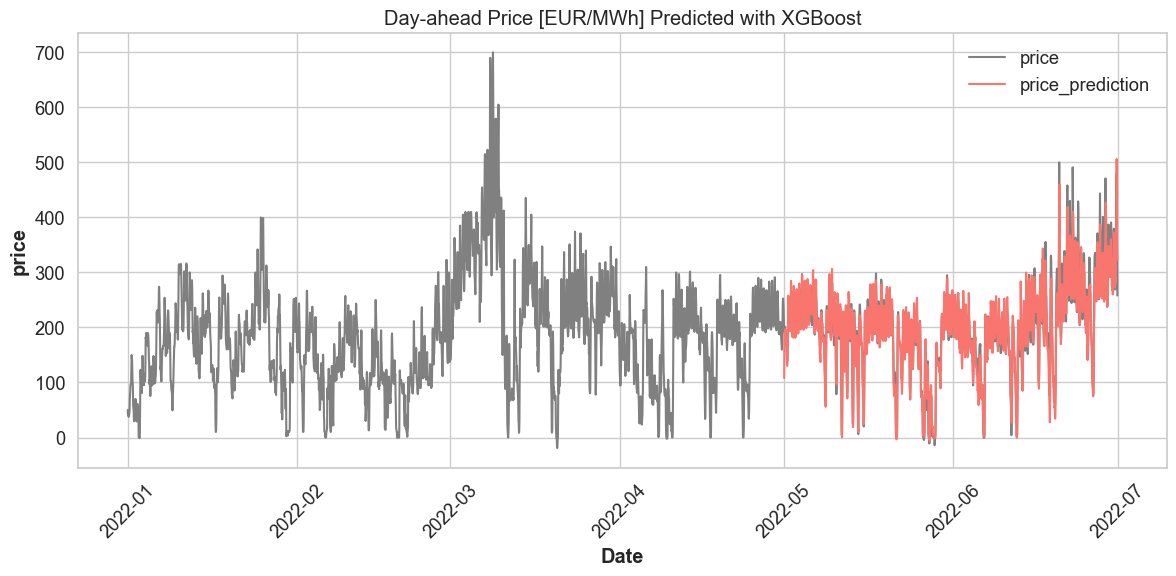

In [188]:
xgb_test['price_prediction'] = reg.predict(X_test)
predicted_XGBoost = pd.concat([xgb_test, xgb_train], sort=False)
plotters.plot_actual_predict(predicted_XGBoost, 'price', 'price_prediction', 'Day-ahead Price [EUR/MWh] Predicted with XGBoost')

In [190]:

xgb_rmse = np.sqrt(mean_squared_error(y_true=xgb_test['price'],
                   y_pred=xgb_test['price_prediction']))

xgb_mae = mean_absolute_error(y_true=xgb_test['price'],
                   y_pred=xgb_test['price_prediction'])

print(f"Root Mean Squared Error: {xgb_rmse}")
print(f"Mean Absolute Error: {xgb_mae}")

Root Mean Squared Error: 22.417533156186156
Mean Absolute Error: 15.197617649392404


old

RMSE: 72.62760400265705

Mean Absolute Error: 54.146453745197284

Mean Absolute Percentage Error: 628587622318244.4

without balance

Mean Squared Error: 42.12097329402923

Mean Absolute Error: 29.980022588835464

-----------

Root Mean Squared Error: 40.878197492053715

Mean Absolute Error: 29.071574118420916

-------------

Root Mean Squared Error: 22.98923363592281

Mean Absolute Error: 15.776761318923102


### ARIMA

ADF Statistic: -6.910400985725894
p-value: 1.2165522240256648e-09
Reject the null hypothesis. The series is likely stationary.


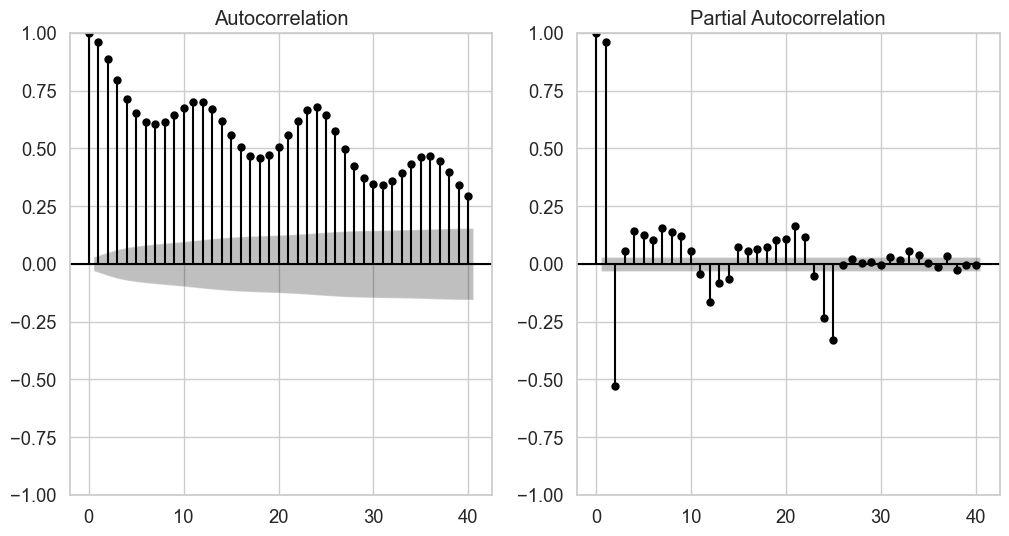

In [191]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

arima_data = merged_data['price']

result = adfuller(arima_data.dropna())

# Output the test statistic and p-value
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation of results
if result[1] <= 0.05:
    print("Reject the null hypothesis. The series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The series is likely non-stationary.")

# Plot ACF and PACF to find p and q
plt.figure(figsize=(12, 6))

# ACF plot for q (Moving Average)
plt.subplot(121)
plot_acf(arima_data, lags=40, ax=plt.gca())

# PACF plot for p (AutoRegressive)
plt.subplot(122)
plot_pacf(arima_data, lags=40, ax=plt.gca())

plt.show()

In [192]:
from statsmodels.tsa.arima.model import ARIMA

arima_train, arima_test = du.ts_train_test_split(merged_data['price'], split_date)

# # Loop over a range of p, d, q values
# best_aic = float('inf')
# best_order = None
# best_model = None

# for p in range(0, 6):  # Testing p values from 0 to 5
#     for d in range(0, 3):  # Testing d values from 0 to 2
#         for q in range(0, 6):  # Testing q values from 0 to 5
#             try:
#                 model = ARIMA(arima_train, order=(p, d, q))
#                 model_fit = model.fit()
#                 if model_fit.aic < best_aic:
#                     best_aic = model_fit.aic
#                     best_order = (p, d, q)
#                     best_model = model_fit
#             except:
#                 continue

# print("--------------------------------")
# print(f'Best ARIMA order: {best_order}')

In [193]:
arima_model = ARIMA(arima_train, order=(4, 1, 4))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.



                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2881
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -12642.207
Date:                Tue, 13 May 2025   AIC                          25302.414
Time:                        00:55:11   BIC                          25356.104
Sample:                    01-01-2022   HQIC                         25321.767
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3903      0.044     53.859      0.000       2.303       2.477
ar.L2         -2.7820      0.090    -30.889      0.000      -2.959      -2.605
ar.L3          1.7704      0.077     23.047      0.0

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [194]:
forecast_steps = len(arima_test)
arima_forecast = arima_model_fit.forecast(steps=forecast_steps)

# Calculate MAE RMSE
arima_rmse = np.sqrt(mean_squared_error(arima_test, arima_forecast))
arima_mae = mean_absolute_error(arima_test, arima_forecast)

print(f"Root Mean Squared Error ARIMA: {arima_rmse}")
print(f"Mean Absolute Error ARIMA: {arima_mae}")

Root Mean Squared Error ARIMA: 80.60131111116841
Mean Absolute Error ARIMA: 57.57410564208863


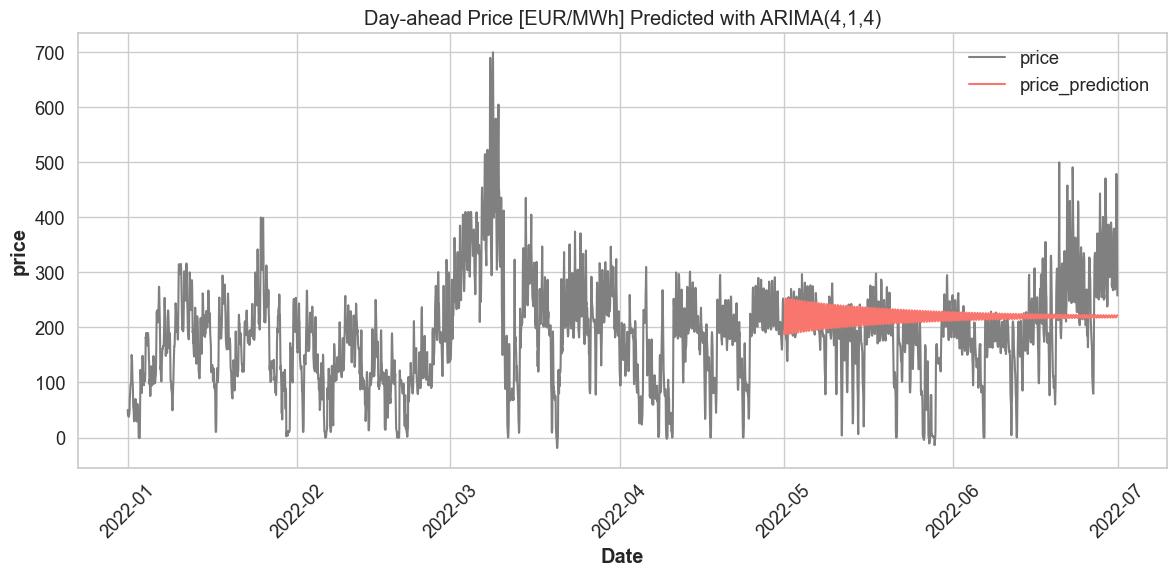

In [195]:
arima_pred_all = merged_data[['price']]
arima_forecast.name = 'price_prediction'
arima_forecast.to_frame()
arima_pred_all = arima_pred_all.join(arima_forecast)

plotters.plot_actual_predict(arima_pred_all, 'price', 'price_prediction', 'Day-ahead Price [EUR/MWh] Predicted with ARIMA(4,1,4)')

### Prophet